In [2]:
%load_ext autoreload
%autoreload 2

In [53]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import Image

from src.directories import processed_data_dir, saved_model_dir, vis_dir
from src.utils import WindowGenerator, get_filenames_in_directory, ModelTrainer

In [4]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

In [5]:
# check GPU visibility
tf.config.get_visible_devices(
    device_type='GPU'
)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
train_dir = processed_data_dir / 'train'
val_dir = processed_data_dir / 'val'
test_dir = processed_data_dir / 'test'

In [7]:
train_files = get_filenames_in_directory(train_dir)

In [8]:
# number of features
# 11
cols = pd.read_csv(train_dir/train_files[0]).columns
n_features = len(cols) -1  # number of columns without embedding column
n_features

11

In [9]:
# number of locations for embedding inputs
# 6
train_files = get_filenames_in_directory(train_dir)
n_locations = len(train_files)
n_locations

6

In [10]:
# Model configs
INPUT_WIDTH = 24  * 3
LABEL_WIDTH = 24
BATCH_SIZE = 32
N_FEATURES = n_features
N_OUTPUTS = 1
N_EMBEDDING_DIMS = n_locations

# Train configs
MAX_EPOCHS = 30
METRICS = [
      tf.keras.metrics.MeanAbsoluteError(name='MAE')
]

In [11]:
w1 = WindowGenerator(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, batch_size=BATCH_SIZE,
                     train_dir=train_dir, val_dir=val_dir, test_dir=test_dir,
                     label_columns=['Lufttemperatur [GradC]'],
                     embedding_column='Location')

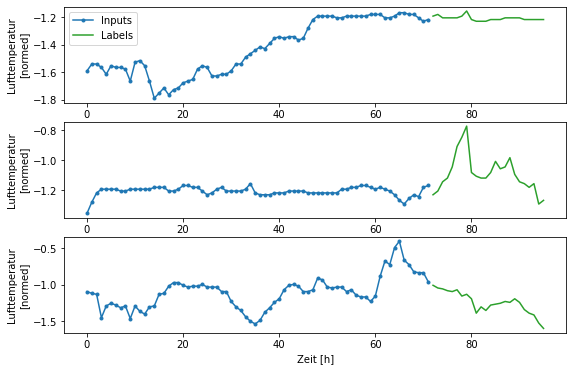

In [12]:
w1.plot(rotate_examples=False)

In [13]:
# container to store model performances
performance = {}

# Baseline model 1: Repeat last hour

In [14]:
# example for testing
# for example in w1.train.take(1):
#     (inputs, embeddings), y = example

In [21]:
class LastStepBaseline(tf.keras.Model):
  def call(self, inputs):
    features, _ = inputs

    temp_at_last_t = tf.expand_dims(features[:, -1:, 1], axis=2)

    return tf.tile(temp_at_last_t, [1, LABEL_WIDTH, 1])

In [33]:
last_step_baseline = ModelTrainer(
    model=LastStepBaseline(),
    name='LastStepBaseline',
    train_dataset = w1.train,
    validation_dataset = w1.val,
    test_dataset = w1.test,
    save_destination = saved_model_dir
)

performance[last_step_baseline.name] = last_step_baseline.evaluate()

546/546 [==============================] - 9s 14ms/step - loss: 0.2936


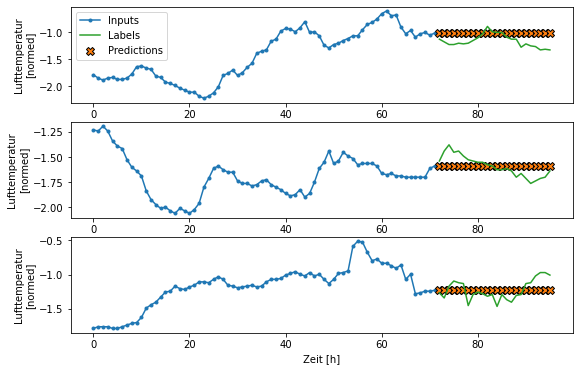

In [34]:
w1.plot(last_step_baseline.model, rotate_examples=True)

# Baseline model 2: Repeat last 24h

In [36]:
class LastDayBaseline(tf.keras.Model):
  def call(self, inputs):
    features, _ = inputs

    return tf.expand_dims(features[:,-24:, 1], axis=2)

In [37]:
last_day_baseline = ModelTrainer(
    model=LastDayBaseline(),
    name='LastDayBaseline',
    train_dataset = w1.train,
    validation_dataset = w1.val,
    test_dataset = w1.test,
    save_destination = saved_model_dir
)

performance[last_day_baseline.name] = last_day_baseline.evaluate()

546/546 [==============================] - 7s 11ms/step - loss: 0.1807


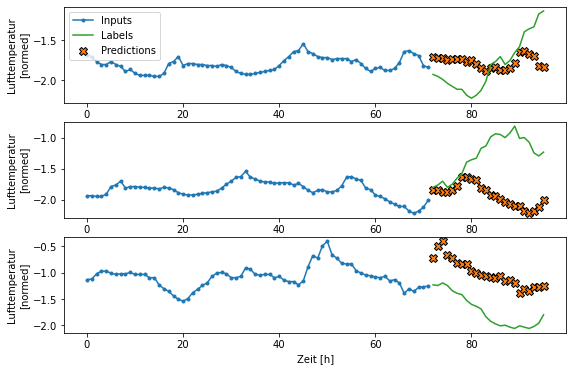

In [38]:
w1.plot(last_day_baseline.model, rotate_examples=True)

# Single layer LSTM w/o embedding

In [54]:
tf.keras.backend.clear_session()

# Deadend input for embeddings
_ = tf.keras.Input(shape =(INPUT_WIDTH, ))

# Input for features
feature_inputs = tf.keras.layers.Input(shape=(INPUT_WIDTH, n_features))

lstm = tf.keras.layers.LSTM(30, return_sequences=False)(feature_inputs)

# Apply a dense output layer on every timestep of the LSTM
output = tf.keras.layers.Dense(LABEL_WIDTH)(lstm)

# Build the model
model = tf.keras.Model(inputs=[feature_inputs, _], outputs=output)

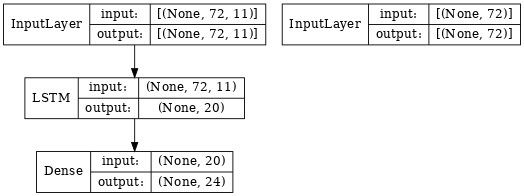

In [62]:
basic_lstm = ModelTrainer(
    model,
    name='Basic LSTM w/o embedding',
    train_dataset=w1.train,
    validation_dataset=w1.val,
    test_dataset=w1.test,
    saved_model_dir=saved_model_dir,
    vis_dir=vis_dir
)

basic_lstm.plot_model()

In [63]:
basic_lstm.fit()

Epoch 1/30
3282/3282 [==============================] - 126s 37ms/step - loss: 0.6168 - val_loss: 0.1764
Epoch 2/30
3282/3282 [==============================] - 113s 34ms/step - loss: 0.1582 - val_loss: 0.1199
Epoch 3/30
3282/3282 [==============================] - 118s 36ms/step - loss: 0.1223 - val_loss: 0.1088
Epoch 4/30
3282/3282 [==============================] - 116s 35ms/step - loss: 0.1130 - val_loss: 0.1039
Epoch 5/30
3282/3282 [==============================] - 117s 35ms/step - loss: 0.1081 - val_loss: 0.1008
Epoch 6/30
3282/3282 [==============================] - 112s 34ms/step - loss: 0.1046 - val_loss: 0.0984
Epoch 7/30
3282/3282 [==============================] - 114s 35ms/step - loss: 0.1015 - val_loss: 0.0969
Epoch 8/30
3282/3282 [==============================] - 108s 33ms/step - loss: 0.0990 - val_loss: 0.0945
Epoch 9/30
3282/3282 [==============================] - 113s 34ms/step - loss: 0.0965 - val_loss: 0.0935
Epoch 10/30
3282/3282 [==============================] 

# Multi layer LSTM

In [32]:
tf.keras.backend.clear_session()

# Input for embeddings
embedding_inputs = tf.keras.Input(shape =(INPUT_WIDTH,))
embedding_layer = tf.keras.layers.Embedding(input_dim=N_EMBEDDING_DIMS + 1, 
                                            output_dim=2, input_length=INPUT_WIDTH)(embedding_inputs)

# Input for features
feature_inputs = tf.keras.layers.Input(shape=(INPUT_WIDTH, n_features))

# Concat embeddings &  features
concat_layer = tf.keras.layers.Concatenate()([embedding_layer, feature_inputs])

lstm_layer = tf.keras.layers.LSTM(13, return_sequences=True)(concat_layer)
lstm_layer = tf.keras.layers.LSTM(13, return_sequences=True)(lstm_layer)
lstm_layer = tf.keras.layers.LSTM(13, return_sequences=True)(lstm_layer)[:,-LABEL_WIDTH:,:]

# Apply a dense output layer on every timestep of the LSTM
output = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(units=1, activation='linear')
)(lstm_layer)

# Build the model
model = tf.keras.Model(inputs=[feature_inputs, embedding_inputs], outputs=output)

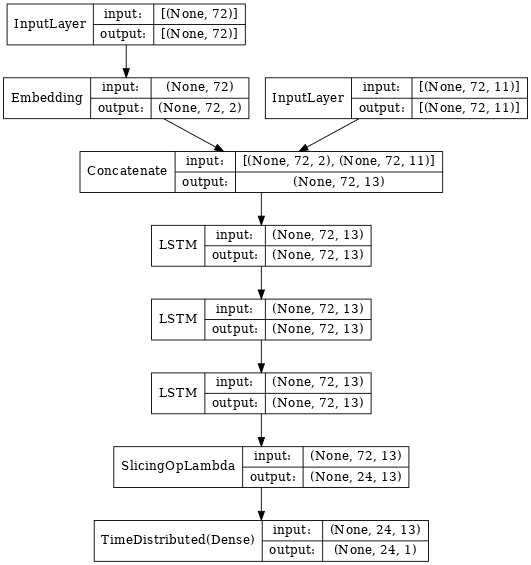

In [18]:
tf.keras.utils.plot_model(
    model, to_file=vis_dir/'forecast_model_architecture.png', show_shapes=True, 
    show_layer_names=False, rankdir='TB', expand_nested=False, dpi=64
)

## Train model

In [49]:
model.save(str(saved_model_dir/model_name))

[2021-08-29 12:01:46 | save] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_2_layer_call_fn while saving (showing 5 of 15). These functions will not be directly callable after loading.
[2021-08-29 12:01:46 | save] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_2_layer_call_fn while saving (showing 5 of 15). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /home/heckert/projects/sbg-weather/data/saved_models/lstm_basic_210829/assets


[2021-08-29 12:01:48 | builder_impl] Assets written to: /home/heckert/projects/sbg-weather/data/saved_models/lstm_basic_210829/assets


Text(0, 0.5, 'val_loss')

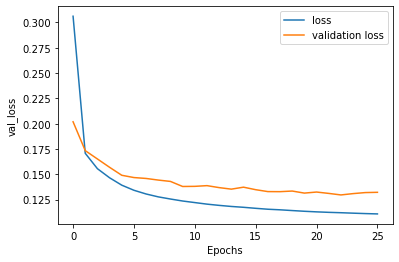

In [50]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(labels = ["loss", "validation loss"])
plt.xlabel("Epochs")
plt.ylabel("val_loss")

In [88]:
model = tf.keras.models.load_model(saved_model_dir/'lstm_basic_210829')

In [97]:
performance['multi_layer_lstm'] = model.evaluate(w1.test, verbose=0)

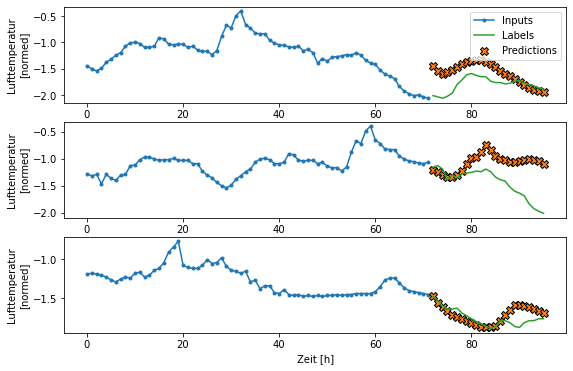

In [94]:
w1.plot(model=model, rotate_examples=True)

# Evaluation

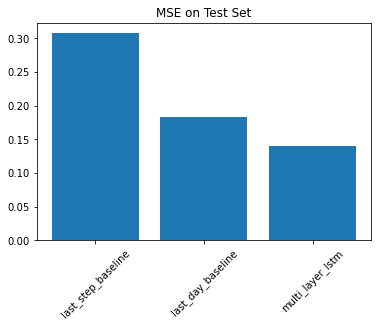

In [109]:
models = performance.keys()
mse = [mse for mse, mae in performance.values()]
x = range(len(models))

plt.bar(x, mse, label=models)
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.title('MSE on Test Set')
plt.show()